# Sensitivity analysis on effect differences from FFT window size

This file generates and displays data for the within-study parameter sensitivity analysis.

In [1]:
# imports
import os
import re
from functools import partial
from math import log
from pathlib import Path

import pandas as pd

import tools.plots as plts
from tools.index_sensitivity import IndexSensitivity
from tools.r_link import Rlink
from study_settings.big_vicky import BigVickySettings, BigVickyToolbox
from study_settings.carara import CararaSettings, CararaToolbox

In [2]:
# settings and r_link
r_link = Rlink()
r_link.capture_rpy2_output(errorwarn_callback=print)
r_link.load_src("tools/r_funcs.R")
indices_of_interest = ["ACI", "ADI", "AEI", "BIO"]
output_path = Path("./output")
fft_window_sizes = [2**x for x in range(8, 16)] + [48000]

In [3]:
def experiment(df:pd.DataFrame, group_to_process:tuple, toolbox:IndexSensitivity, r_link:Rlink, marine:bool, factors:list, cross_effect:str):
    '''
    Models and obtains conditional effects for every set of values in the dataframe. Sets are defined by grouping the "Index", "Filtered", and "Band" columns.
    This function is designed for use in this notebook and may not generalise well.

    df: dataframe of index values
    group_to_process: tuple with the multi-index of the group to model
    toolbox: an instance of the IndexSensitivity class, with settings relevant to the data and models
    r_link: an instance of the Rlink class
    marine: whether the data is from Big Vicky's (True) or Carara (False)
    factors: which columns to treat as factors
    cross_effect: which column is treated as the cross effect (along with Window) 

    returns: a matplotlib figure of the model, and a table with the posterior effects summary
    '''
    samp_to_s = partial(toolbox.samples_to_s, toolbox.settings.sample_rate)
    s_to_samp = partial(toolbox.s_to_samples, toolbox.settings.sample_rate)
    conditional_effects = {}
    grouped_data = df.groupby(['Index', 'Filtered', 'Band']) 
    group = grouped_data.get_group(group_to_process).copy()
    index, filtered, band = group_to_process
    log_window = index != "AEI"
    if log_window:
        group["Window"] = group["Window"].apply(lambda x: log(x))

    if index not in conditional_effects:
        conditional_effects[index] = {True: {}, False: {}}

    txt = '_filtered' if filtered else ''
    flt = txt.replace('_', ' ')
    all_text = (index, flt, band, cross_effect)
    model, effects = toolbox.build_model(r_link, marine, all_text, group, factors)
    filename = output_path / f"{cross_effect}_x_Window_conditional_effects_for_{index}_over{txt}_{band}_frequencies_Python"
    secax = ("Window duration (s)", (samp_to_s, s_to_samp))
    fig = plts.plot_conditional_effects(r_link,
                                    filename, 
                                    effects, 
                                    plot_points=True, 
                                    sec_ax=secax, 
                                    colors=toolbox.settings.colors, 
                                    unlog=log_window)
    conditional_effects[index][filtered][band] = effects
    posterior_ratios = r_link.r_src.get_posterior_ratios(model, num=toolbox.settings.num, den=toolbox.settings.den, cross=cross_effect)
    posterior_effects = r_link.r_src.get_posterior_ratio_summary(posterior_ratios)

    warnings = r_link.r_src.get_warnings()
    if warnings != r_link.null_value:
        print(warnings)

    return fig, posterior_effects

In [4]:
# from tools.populate_ipynb import CellAdder
# print(CellAdder.generate_index_definitions())

In [5]:
# index definitions
broadband_ACI_group = ('ACI', False, 'broadband')
broadband_ADI_group = ('ADI', False, 'broadband')
broadband_AEI_group = ('AEI', False, 'broadband')
broadband_BIO_group = ('BIO', False, 'broadband')
fish_extracted_ACI_group = ('ACI', False, 'fish')
fish_extracted_ADI_group = ('ADI', False, 'fish')
fish_extracted_AEI_group = ('AEI', False, 'fish')
fish_extracted_BIO_group = ('BIO', False, 'fish')
fish_filtered_ACI_group = ('ACI', True, 'fish')
fish_filtered_ADI_group = ('ADI', True, 'fish')
fish_filtered_AEI_group = ('AEI', True, 'fish')
fish_filtered_BIO_group = ('BIO', True, 'fish')
shrimp_extracted_ACI_group = ('ACI', False, 'shrimp')
shrimp_extracted_ADI_group = ('ADI', False, 'shrimp')
shrimp_extracted_AEI_group = ('AEI', False, 'shrimp')
shrimp_extracted_BIO_group = ('BIO', False, 'shrimp')
shrimp_filtered_ACI_group = ('ACI', True, 'shrimp')
shrimp_filtered_ADI_group = ('ADI', True, 'shrimp')
shrimp_filtered_AEI_group = ('AEI', True, 'shrimp')
shrimp_filtered_BIO_group = ('BIO', True, 'shrimp')

## Carara

In [6]:
# settings and frequency bands
carara_settings = CararaSettings
carara_settings.data_location = os.path.expanduser(carara_settings.data_location)
test_bands = [("broadband", (0, carara_settings.max_freq), False)]


In [7]:
carara_toolbox = CararaToolbox(carara_settings, fft_window_sizes, test_bands, indices_of_interest)

In [8]:
carara_index_values = carara_toolbox.get_index_values(output_file="output/terrestrial_index_values")

In [9]:
carara_df = carara_toolbox.create_dataframe(carara_index_values, output_path="output/terrestrial_dataframe.pkl")

### Carara - broadband ACI


In [10]:
carara_broadband_ACI_fig, carara_broadband_ACI_ratio_summary = experiment(carara_df,
          broadband_ACI_group,
          carara_toolbox,
          r_link,
          marine=False,
          factors=['Site'],
          cross_effect='Site')


broadband using ACI
Compiling Stan program...

Start sampling

starting worker pid=77229 on localhost:11426 at 09:14:38.013
starting worker pid=77244 on localhost:11426 at 09:14:38.083
starting worker pid=77259 on localhost:11426 at 09:14:38.152
starting worker pid=77274 on localhost:11426 at 09:14:38.221
starting worker pid=77289 on localhost:11426 at 09:14:38.290

SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.000117 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 1.17 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 3000 [  0%]  (Warmup)

SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 2).
Chain 2: 
Chain 2: Gradient evaluation took 0.000129 seconds
Chain 2: 1000 transitions using 10 leapfrog steps per transition would take 1.29 seconds.
Chain 2: Adjust your expectations accordingly!
Chain 2: 
Chain 2: 
Chain 2: Iteration:    1 / 3000 [  0%]  (Warmup)
Ch

/home/00112847/code/index_sensitivity/tools/plots.py:61: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for var_id, group in point_df.groupby(effect_names[1]):
/home/00112847/code/index_sensitivity/tools/plots.py:73: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for var_id, group in df.groupby(effect_names[1]):


In [11]:
print(carara_broadband_ACI_ratio_summary)


# A tibble: 9 × 7
  Window     y  ymin  ymax .width .point .interval
   <dbl> <dbl> <dbl> <dbl>  <dbl> <chr>  <chr>    
1   5.55  1.70  1.59  1.81   0.95 median hdci     
2   6.24  1.72  1.63  1.81   0.95 median hdci     
3   6.93  1.74  1.66  1.82   0.95 median hdci     
4   7.62  1.76  1.69  1.82   0.95 median hdci     
5   8.32  1.78  1.72  1.84   0.95 median hdci     
6   9.01  1.80  1.73  1.87   0.95 median hdci     
7   9.70  1.82  1.75  1.91   0.95 median hdci     
8  10.4   1.85  1.75  1.95   0.95 median hdci     
9  10.8   1.86  1.74  1.97   0.95 median hdci     



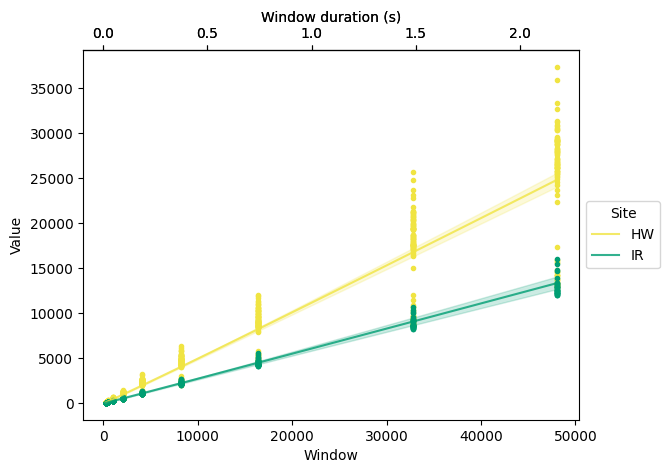

In [12]:
carara_broadband_ACI_fig


### Carara - broadband ADI


In [13]:
carara_broadband_ADI_fig, carara_broadband_ADI_ratio_summary = experiment(carara_df,
          broadband_ADI_group,
          carara_toolbox,
          r_link,
          marine=False,
          factors=['Site'],
          cross_effect='Site')


broadband using ADI
Compiling Stan program...

Start sampling

starting worker pid=77558 on localhost:11426 at 09:15:26.214
starting worker pid=77573 on localhost:11426 at 09:15:26.284
starting worker pid=77588 on localhost:11426 at 09:15:26.353
starting worker pid=77603 on localhost:11426 at 09:15:26.422
starting worker pid=77618 on localhost:11426 at 09:15:26.491

SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 9.9e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.99 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 3000 [  0%]  (Warmup)

SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 2).
Chain 2: 
Chain 2: Gradient evaluation took 0.000106 seconds
Chain 2: 1000 transitions using 10 leapfrog steps per transition would take 1.06 seconds.
Chain 2: Adjust your expectations accordingly!
Chain 2: 
Chain 2: 
Chain 2: Iteration:    1 / 3000 [  0%]  (Warmup)
Cha

/home/00112847/code/index_sensitivity/tools/plots.py:61: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for var_id, group in point_df.groupby(effect_names[1]):
/home/00112847/code/index_sensitivity/tools/plots.py:73: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for var_id, group in df.groupby(effect_names[1]):


In [14]:
print(carara_broadband_ADI_ratio_summary)


# A tibble: 9 × 7
  Window     y  ymin  ymax .width .point .interval
   <dbl> <dbl> <dbl> <dbl>  <dbl> <chr>  <chr>    
1   5.55 0.943 0.882 1.00    0.95 median hdci     
2   6.24 0.948 0.896 0.998   0.95 median hdci     
3   6.93 0.953 0.912 0.996   0.95 median hdci     
4   7.62 0.958 0.925 0.996   0.95 median hdci     
5   8.32 0.964 0.933 0.999   0.95 median hdci     
6   9.01 0.969 0.931 1.00    0.95 median hdci     
7   9.70 0.974 0.933 1.02    0.95 median hdci     
8  10.4  0.980 0.928 1.04    0.95 median hdci     
9  10.8  0.982 0.926 1.05    0.95 median hdci     



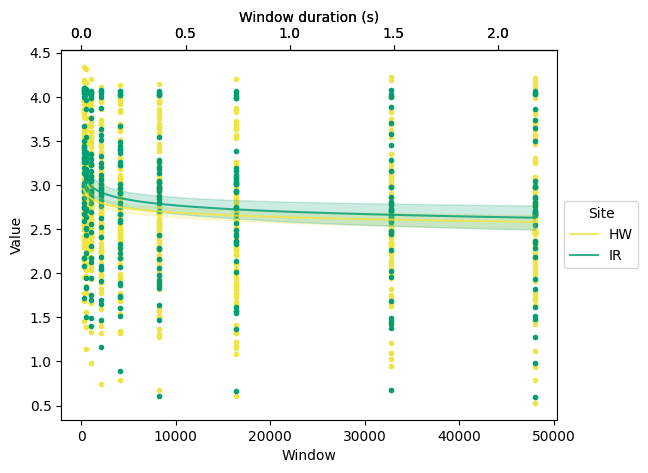

In [15]:
carara_broadband_ADI_fig


### Carara - broadband AEI


In [16]:
carara_broadband_AEI_fig, carara_broadband_AEI_ratio_summary = experiment(carara_df,
          broadband_AEI_group,
          carara_toolbox,
          r_link,
          marine=False,
          factors=['Site'],
          cross_effect='Site')


broadband using AEI
Compiling Stan program...

Start sampling

starting worker pid=77858 on localhost:11426 at 09:16:14.500
starting worker pid=77873 on localhost:11426 at 09:16:14.568
starting worker pid=77888 on localhost:11426 at 09:16:14.636
starting worker pid=77903 on localhost:11426 at 09:16:14.704
starting worker pid=77918 on localhost:11426 at 09:16:14.772

SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.000144 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 1.44 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 3000 [  0%]  (Warmup)

SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 2).
Chain 2: 
Chain 2: Gradient evaluation took 0.000142 seconds
Chain 2: 1000 transitions using 10 leapfrog steps per transition would take 1.42 seconds.
Chain 2: Adjust your expectations accordingly!
Chain 2: 
Chain 2: 
Chain 2: Iteration:    1 / 3000 [  0%]  (Warmup)

S

/home/00112847/code/index_sensitivity/tools/plots.py:61: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for var_id, group in point_df.groupby(effect_names[1]):
/home/00112847/code/index_sensitivity/tools/plots.py:73: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for var_id, group in df.groupby(effect_names[1]):


In [17]:
print(carara_broadband_AEI_ratio_summary)


# A tibble: 9 × 7
  Window     y  ymin  ymax .width .point .interval
   <int> <dbl> <dbl> <dbl>  <dbl> <chr>  <chr>    
1    256  1.04 1.02   1.06   0.95 median hdci     
2    512  1.04 1.02   1.06   0.95 median hdci     
3   1024  1.04 1.02   1.05   0.95 median hdci     
4   2048  1.04 1.02   1.05   0.95 median hdci     
5   4096  1.04 1.02   1.05   0.95 median hdci     
6   8192  1.03 1.02   1.05   0.95 median hdci     
7  16384  1.03 1.01   1.04   0.95 median hdci     
8  32768  1.02 0.998  1.04   0.95 median hdci     
9  48000  1.01 0.986  1.04   0.95 median hdci     



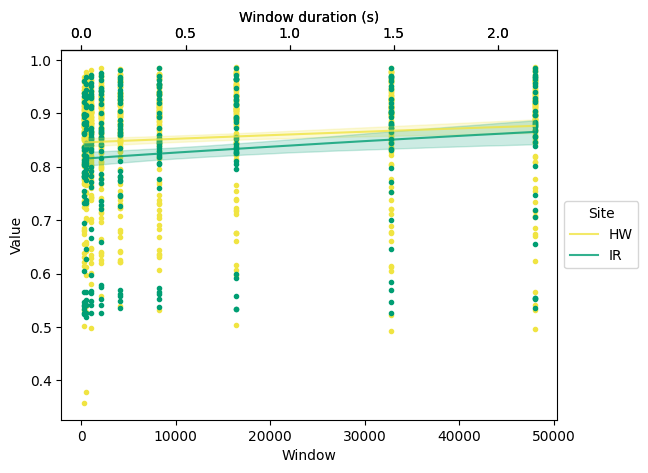

In [18]:
carara_broadband_AEI_fig


### Carara - broadband BIO


In [19]:
carara_broadband_BIO_fig, carara_broadband_BIO_ratio_summary = experiment(carara_df,
          broadband_BIO_group,
          carara_toolbox,
          r_link,
          marine=False,
          factors=['Site'],
          cross_effect='Site')


broadband using BIO
Compiling Stan program...

Start sampling

starting worker pid=78763 on localhost:11426 at 09:21:00.384
starting worker pid=78778 on localhost:11426 at 09:21:00.454
starting worker pid=78793 on localhost:11426 at 09:21:00.524
starting worker pid=78808 on localhost:11426 at 09:21:00.592
starting worker pid=78823 on localhost:11426 at 09:21:00.661

SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.000239 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 2.39 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 3000 [  0%]  (Warmup)

SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 2).
Chain 2: 
Chain 2: Gradient evaluation took 0.00024 seconds
Chain 2: 1000 transitions using 10 leapfrog steps per transition would take 2.4 seconds.
Chain 2: Adjust your expectations accordingly!
Chain 2: 
Chain 2: 
Chain 2: Iteration:    1 / 3000 [  0%]  (Warmup)

SAM

/home/00112847/code/index_sensitivity/tools/plots.py:61: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for var_id, group in point_df.groupby(effect_names[1]):
/home/00112847/code/index_sensitivity/tools/plots.py:73: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for var_id, group in df.groupby(effect_names[1]):


In [20]:
print(carara_broadband_BIO_ratio_summary)


# A tibble: 9 × 7
  Window     y  ymin  ymax .width .point .interval
   <dbl> <dbl> <dbl> <dbl>  <dbl> <chr>  <chr>    
1   5.55  4.37  3.73  5.06   0.95 median hdci     
2   6.24  4.38  3.86  4.96   0.95 median hdci     
3   6.93  4.40  3.96  4.86   0.95 median hdci     
4   7.62  4.42  4.03  4.79   0.95 median hdci     
5   8.32  4.44  4.08  4.79   0.95 median hdci     
6   9.01  4.45  4.06  4.84   0.95 median hdci     
7   9.70  4.47  4.04  4.97   0.95 median hdci     
8  10.4   4.49  3.95  5.09   0.95 median hdci     
9  10.8   4.50  3.89  5.16   0.95 median hdci     



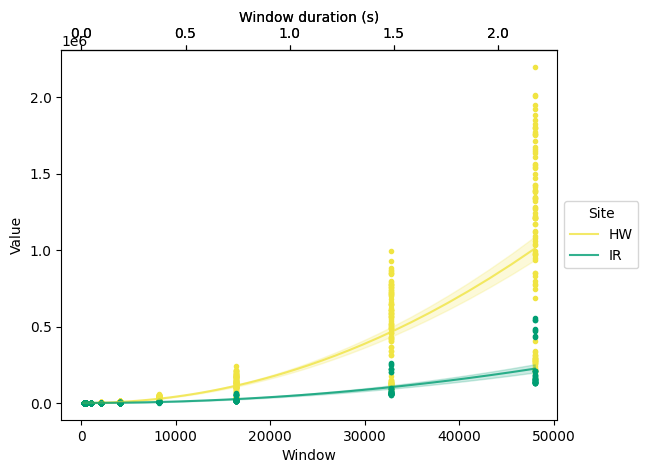

In [21]:
carara_broadband_BIO_fig


## Big Vicky

In [22]:
# settings and frequency bands
vicky_settings = BigVickySettings
vicky_settings.data_location = os.path.expanduser(vicky_settings.data_location)
test_bands = [("broadband", (0, vicky_settings.sample_rate), False),
              ("shrimp", vicky_settings.shrimp_frequencies, False),
              ("shrimp", vicky_settings.shrimp_frequencies, True),
              ("fish", vicky_settings.fish_frequencies, False),
              ("fish", vicky_settings.fish_frequencies, True)]


In [23]:
vicky_toolbox = BigVickyToolbox(vicky_settings, fft_window_sizes, test_bands, indices_of_interest)

In [24]:
vicky_index_values = vicky_toolbox.get_index_values(output_file="output/vicky_index_values.pkl")

In [25]:
vicky_df = vicky_toolbox.create_dataframe(vicky_index_values, output_path="output/vicky_dataframe.pkl")

### Big Vicky - broadband ACI


In [26]:
vicky_extracted_broadband_ACI_fig, vicky_extracted_broadband_ACI_ratio_summary = experiment(vicky_df,
          broadband_ACI_group,
          vicky_toolbox,
          r_link,
          marine=True,
          factors=['Hour', 'Site'],
          cross_effect='Hour')


broadband using ACI
Compiling Stan program...

Start sampling

starting worker pid=86191 on localhost:11426 at 11:25:39.433
starting worker pid=86206 on localhost:11426 at 11:25:39.504
starting worker pid=86221 on localhost:11426 at 11:25:39.573
starting worker pid=86236 on localhost:11426 at 11:25:39.642
starting worker pid=86251 on localhost:11426 at 11:25:39.712

SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.000425 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 4.25 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 3000 [  0%]  (Warmup)

SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 2).
Chain 2: 
Chain 2: Gradient evaluation took 0.000452 seconds
Chain 2: 1000 transitions using 10 leapfrog steps per transition would take 4.52 seconds.
Chain 2: Adjust your expectations accordingly!
Chain 2: 
Chain 2: 
Chain 2: Iteration:    1 / 3000 [  0%]  (Warmup)

S

/home/00112847/code/index_sensitivity/tools/plots.py:61: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for var_id, group in point_df.groupby(effect_names[1]):
/home/00112847/code/index_sensitivity/tools/plots.py:73: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for var_id, group in df.groupby(effect_names[1]):


In [27]:
print(vicky_extracted_broadband_ACI_ratio_summary)


# A tibble: 9 × 7
  Window     y  ymin  ymax .width .point .interval
   <dbl> <dbl> <dbl> <dbl>  <dbl> <chr>  <chr>    
1   5.55  1.01  1.00  1.01   0.95 median hdci     
2   6.24  1.02  1.01  1.02   0.95 median hdci     
3   6.93  1.03  1.03  1.04   0.95 median hdci     
4   7.62  1.05  1.04  1.05   0.95 median hdci     
5   8.32  1.06  1.06  1.06   0.95 median hdci     
6   9.01  1.07  1.07  1.08   0.95 median hdci     
7   9.70  1.09  1.08  1.09   0.95 median hdci     
8  10.4   1.10  1.09  1.10   0.95 median hdci     
9  10.8   1.11  1.10  1.11   0.95 median hdci     



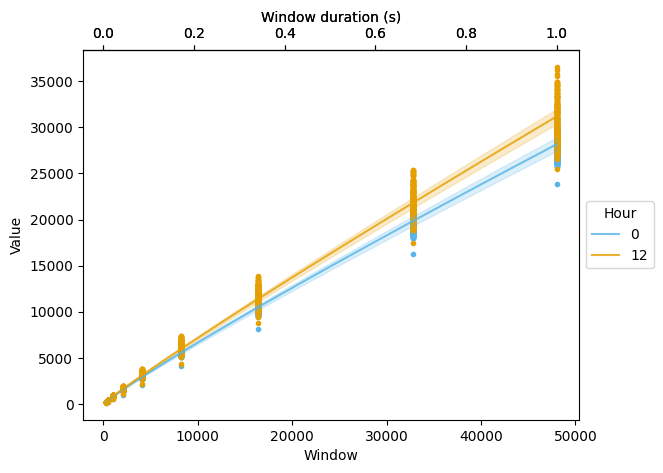

In [28]:
vicky_extracted_broadband_ACI_fig


### Big Vicky - extracted fish ACI


In [29]:
vicky_extracted_fish_ACI_fig, vicky_extracted_fish_ACI_ratio_summary = experiment(vicky_df,
          fish_extracted_ACI_group,
          vicky_toolbox,
          r_link,
          marine=True,
          factors=['Hour', 'Site'],
          cross_effect='Hour')


fish using ACI
Compiling Stan program...

Start sampling

starting worker pid=87160 on localhost:11426 at 11:29:08.372
starting worker pid=87175 on localhost:11426 at 11:29:08.440
starting worker pid=87190 on localhost:11426 at 11:29:08.508
starting worker pid=87205 on localhost:11426 at 11:29:08.575
starting worker pid=87220 on localhost:11426 at 11:29:08.641

SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.000526 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 5.26 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 3000 [  0%]  (Warmup)

SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 2).
Chain 2: 
Chain 2: Gradient evaluation took 0.000562 seconds
Chain 2: 1000 transitions using 10 leapfrog steps per transition would take 5.62 seconds.
Chain 2: Adjust your expectations accordingly!
Chain 2: 
Chain 2: 
Chain 2: Iteration:    1 / 3000 [  0%]  (Warmup)

SAMPLI

/home/00112847/code/index_sensitivity/tools/plots.py:61: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for var_id, group in point_df.groupby(effect_names[1]):
/home/00112847/code/index_sensitivity/tools/plots.py:73: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for var_id, group in df.groupby(effect_names[1]):


In [30]:
print(vicky_extracted_fish_ACI_ratio_summary)


# A tibble: 9 × 7
  Window     y  ymin  ymax .width .point .interval
   <dbl> <dbl> <dbl> <dbl>  <dbl> <chr>  <chr>    
1   5.55 0.931 0.923 0.939   0.95 median hdci     
2   6.24 0.942 0.935 0.949   0.95 median hdci     
3   6.93 0.953 0.947 0.959   0.95 median hdci     
4   7.62 0.964 0.959 0.969   0.95 median hdci     
5   8.32 0.975 0.971 0.980   0.95 median hdci     
6   9.01 0.987 0.982 0.992   0.95 median hdci     
7   9.70 0.998 0.992 1.00    0.95 median hdci     
8  10.4  1.01  1.00  1.02    0.95 median hdci     
9  10.8  1.02  1.01  1.02    0.95 median hdci     



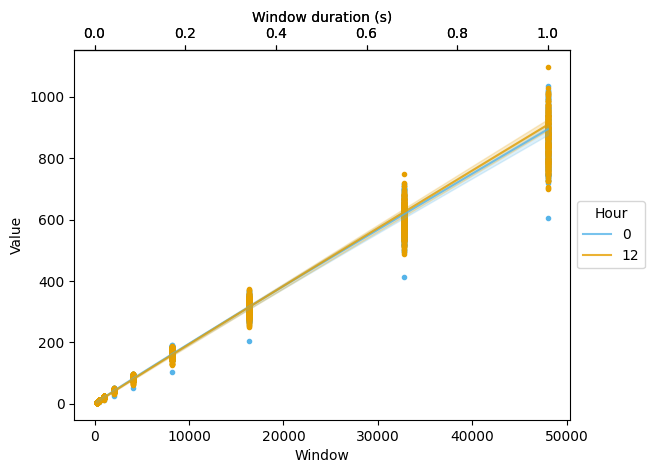

In [31]:
vicky_extracted_fish_ACI_fig


### Big Vicky - extracted shrimp ACI


In [32]:
vicky_extracted_shrimp_ACI_fig, vicky_extracted_shrimp_ACI_ratio_summary = experiment(vicky_df,
          shrimp_extracted_ACI_group,
          vicky_toolbox,
          r_link,
          marine=True,
          factors=['Hour', 'Site'],
          cross_effect='Hour')


shrimp using ACI
Compiling Stan program...

Start sampling

starting worker pid=87698 on localhost:11426 at 11:31:03.597
starting worker pid=87713 on localhost:11426 at 11:31:03.665
starting worker pid=87728 on localhost:11426 at 11:31:03.733
starting worker pid=87743 on localhost:11426 at 11:31:03.801
starting worker pid=87758 on localhost:11426 at 11:31:03.868

SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.000762 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 7.62 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 3000 [  0%]  (Warmup)

SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 2).
Chain 2: 
Chain 2: Gradient evaluation took 0.000721 seconds
Chain 2: 1000 transitions using 10 leapfrog steps per transition would take 7.21 seconds.
Chain 2: Adjust your expectations accordingly!
Chain 2: 
Chain 2: 
Chain 2: Iteration:    1 / 3000 [  0%]  (Warmup)

SAMP

/home/00112847/code/index_sensitivity/tools/plots.py:61: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for var_id, group in point_df.groupby(effect_names[1]):
/home/00112847/code/index_sensitivity/tools/plots.py:73: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for var_id, group in df.groupby(effect_names[1]):


In [33]:
print(vicky_extracted_shrimp_ACI_ratio_summary)


# A tibble: 9 × 7
  Window     y  ymin  ymax .width .point .interval
   <dbl> <dbl> <dbl> <dbl>  <dbl> <chr>  <chr>    
1   5.55  1.00 0.994  1.01   0.95 median hdci     
2   6.24  1.02 1.01   1.02   0.95 median hdci     
3   6.93  1.04 1.03   1.04   0.95 median hdci     
4   7.62  1.06 1.05   1.06   0.95 median hdci     
5   8.32  1.07 1.07   1.08   0.95 median hdci     
6   9.01  1.09 1.09   1.10   0.95 median hdci     
7   9.70  1.11 1.11   1.12   0.95 median hdci     
8  10.4   1.13 1.13   1.14   0.95 median hdci     
9  10.8   1.15 1.14   1.15   0.95 median hdci     



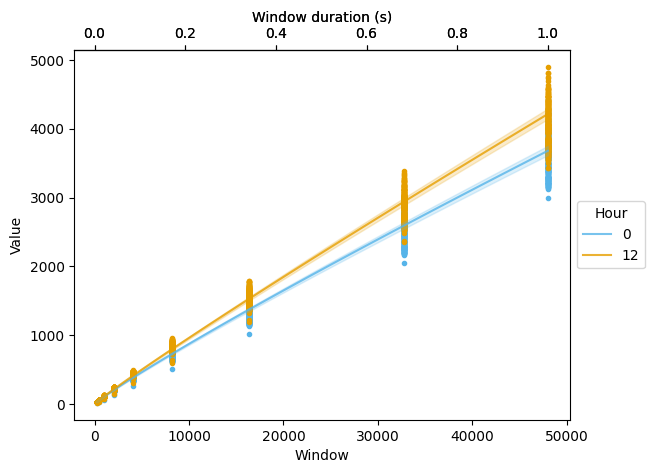

In [34]:
vicky_extracted_shrimp_ACI_fig


### Big Vicky - filtered fish ACI


In [35]:
vicky_filtered_fish_ACI_fig, vicky_filtered_fish_ACI_ratio_summary = experiment(vicky_df,
          fish_filtered_ACI_group,
          vicky_toolbox,
          r_link,
          marine=True,
          factors=['Hour', 'Site'],
          cross_effect='Hour')


fish  filteredusing ACI
Compiling Stan program...

Start sampling

starting worker pid=88277 on localhost:11426 at 11:33:25.873
starting worker pid=88292 on localhost:11426 at 11:33:25.941
starting worker pid=88307 on localhost:11426 at 11:33:26.009
starting worker pid=88322 on localhost:11426 at 11:33:26.077
starting worker pid=88337 on localhost:11426 at 11:33:26.144

SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.000773 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 7.73 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 3000 [  0%]  (Warmup)

SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 2).
Chain 2: 
Chain 2: Gradient evaluation took 0.000711 seconds
Chain 2: 1000 transitions using 10 leapfrog steps per transition would take 7.11 seconds.
Chain 2: Adjust your expectations accordingly!
Chain 2: 
Chain 2: 
Chain 2: Iteration:    1 / 3000 [  0%]  (Warmup

/home/00112847/code/index_sensitivity/tools/plots.py:61: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for var_id, group in point_df.groupby(effect_names[1]):
/home/00112847/code/index_sensitivity/tools/plots.py:73: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for var_id, group in df.groupby(effect_names[1]):


In [36]:
print(vicky_filtered_fish_ACI_ratio_summary)


# A tibble: 9 × 7
  Window     y  ymin  ymax .width .point .interval
   <dbl> <dbl> <dbl> <dbl>  <dbl> <chr>  <chr>    
1   5.55  1.01  1.00  1.01   0.95 median hdci     
2   6.24  1.01  1.01  1.01   0.95 median hdci     
3   6.93  1.01  1.01  1.01   0.95 median hdci     
4   7.62  1.01  1.01  1.01   0.95 median hdci     
5   8.32  1.01  1.01  1.01   0.95 median hdci     
6   9.01  1.01  1.01  1.02   0.95 median hdci     
7   9.70  1.02  1.01  1.02   0.95 median hdci     
8  10.4   1.02  1.02  1.02   0.95 median hdci     
9  10.8   1.02  1.02  1.02   0.95 median hdci     



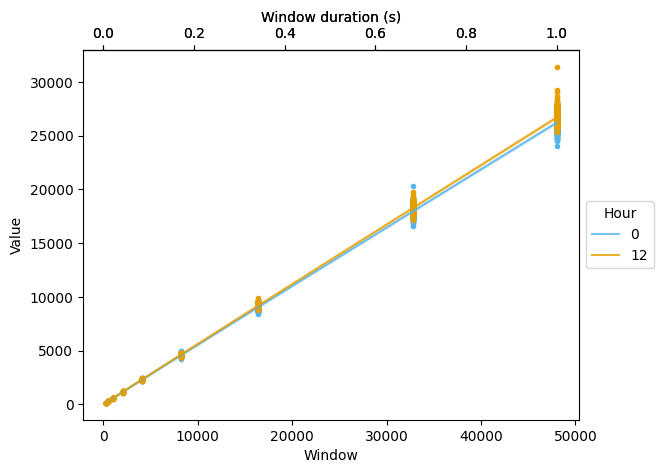

In [37]:
vicky_filtered_fish_ACI_fig


### Big Vicky - filtered shrimp ACI


In [38]:
vicky_filtered_shrimp_ACI_fig, vicky_filtered_shrimp_ACI_ratio_summary = experiment(vicky_df,
          shrimp_filtered_ACI_group,
          vicky_toolbox,
          r_link,
          marine=True,
          factors=['Hour', 'Site'],
          cross_effect='Hour')


shrimp  filteredusing ACI
Compiling Stan program...

Start sampling

starting worker pid=89663 on localhost:11426 at 11:40:56.354
starting worker pid=89678 on localhost:11426 at 11:40:56.423
starting worker pid=89693 on localhost:11426 at 11:40:56.490
starting worker pid=89708 on localhost:11426 at 11:40:56.556
starting worker pid=89723 on localhost:11426 at 11:40:56.624

SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.000714 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 7.14 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 3000 [  0%]  (Warmup)

SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 2).
Chain 2: 
Chain 2: Gradient evaluation took 0.000706 seconds
Chain 2: 1000 transitions using 10 leapfrog steps per transition would take 7.06 seconds.
Chain 2: Adjust your expectations accordingly!
Chain 2: 
Chain 2: 
Chain 2: Iteration:    1 / 3000 [  0%]  (Warm

/home/00112847/code/index_sensitivity/tools/plots.py:61: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for var_id, group in point_df.groupby(effect_names[1]):
/home/00112847/code/index_sensitivity/tools/plots.py:73: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for var_id, group in df.groupby(effect_names[1]):


In [39]:
print(vicky_filtered_shrimp_ACI_ratio_summary)


# A tibble: 9 × 7
  Window     y  ymin  ymax .width .point .interval
   <dbl> <dbl> <dbl> <dbl>  <dbl> <chr>  <chr>    
1   5.55  1.01  1.01  1.01   0.95 median hdci     
2   6.24  1.02  1.02  1.02   0.95 median hdci     
3   6.93  1.03  1.02  1.03   0.95 median hdci     
4   7.62  1.03  1.03  1.03   0.95 median hdci     
5   8.32  1.04  1.04  1.04   0.95 median hdci     
6   9.01  1.05  1.05  1.05   0.95 median hdci     
7   9.70  1.05  1.05  1.06   0.95 median hdci     
8  10.4   1.06  1.06  1.06   0.95 median hdci     
9  10.8   1.06  1.06  1.07   0.95 median hdci     



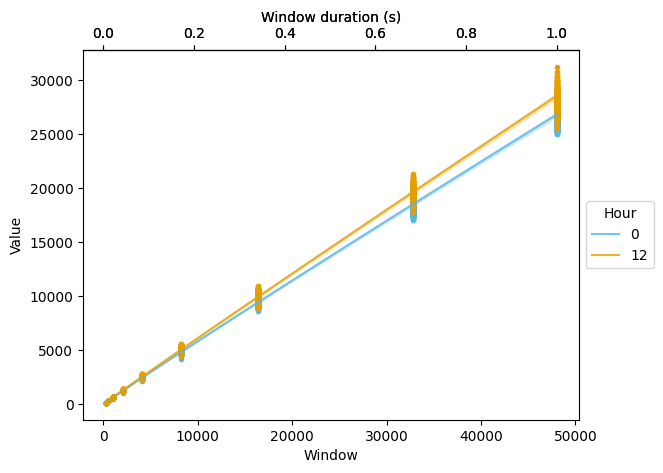

In [40]:
vicky_filtered_shrimp_ACI_fig


### Big Vicky - broadband ADI


In [41]:
vicky_extracted_broadband_ADI_fig, vicky_extracted_broadband_ADI_ratio_summary = experiment(vicky_df,
          broadband_ADI_group,
          vicky_toolbox,
          r_link,
          marine=True,
          factors=['Hour', 'Site'],
          cross_effect='Hour')


broadband using ADI
Compiling Stan program...

Start sampling

starting worker pid=90850 on localhost:11426 at 11:46:19.802
starting worker pid=90865 on localhost:11426 at 11:46:19.869
starting worker pid=90880 on localhost:11426 at 11:46:19.937
starting worker pid=90895 on localhost:11426 at 11:46:20.005
starting worker pid=90910 on localhost:11426 at 11:46:20.072

SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.000711 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 7.11 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 3000 [  0%]  (Warmup)

SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 2).
Chain 2: 
Chain 2: Gradient evaluation took 0.000718 seconds
Chain 2: 1000 transitions using 10 leapfrog steps per transition would take 7.18 seconds.
Chain 2: Adjust your expectations accordingly!
Chain 2: 
Chain 2: 
Chain 2: Iteration:    1 / 3000 [  0%]  (Warmup)

S

/home/00112847/code/index_sensitivity/tools/plots.py:61: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for var_id, group in point_df.groupby(effect_names[1]):
/home/00112847/code/index_sensitivity/tools/plots.py:73: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for var_id, group in df.groupby(effect_names[1]):


In [42]:
print(vicky_extracted_broadband_ADI_ratio_summary)


# A tibble: 9 × 7
  Window     y  ymin  ymax .width .point .interval
   <dbl> <dbl> <dbl> <dbl>  <dbl> <chr>  <chr>    
1   5.55 1.03  1.03  1.04    0.95 median hdci     
2   6.24 1.02  1.02  1.03    0.95 median hdci     
3   6.93 1.01  1.01  1.02    0.95 median hdci     
4   7.62 1.01  1.00  1.01    0.95 median hdci     
5   8.32 0.997 0.994 1.00    0.95 median hdci     
6   9.01 0.988 0.985 0.991   0.95 median hdci     
7   9.70 0.979 0.975 0.983   0.95 median hdci     
8  10.4  0.971 0.966 0.976   0.95 median hdci     
9  10.8  0.966 0.961 0.971   0.95 median hdci     



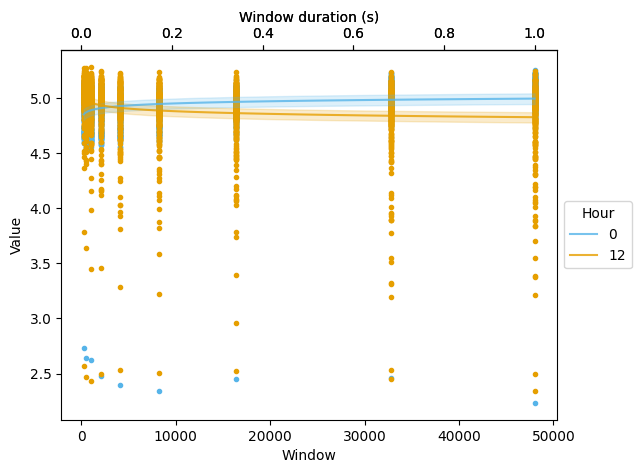

In [43]:
vicky_extracted_broadband_ADI_fig


### Big Vicky - extracted fish ADI


In [44]:
vicky_extracted_fish_ADI_fig, vicky_extracted_fish_ADI_ratio_summary = experiment(vicky_df,
          fish_extracted_ADI_group,
          vicky_toolbox,
          r_link,
          marine=True,
          factors=['Hour', 'Site'],
          cross_effect='Hour')


fish using ADI
Compiling Stan program...

Start sampling

starting worker pid=91450 on localhost:11426 at 11:48:38.063
starting worker pid=91465 on localhost:11426 at 11:48:38.132
starting worker pid=91480 on localhost:11426 at 11:48:38.200
starting worker pid=91495 on localhost:11426 at 11:48:38.268
starting worker pid=91510 on localhost:11426 at 11:48:38.335

SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.000748 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 7.48 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 3000 [  0%]  (Warmup)

SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 2).
Chain 2: 
Chain 2: Gradient evaluation took 0.000756 seconds
Chain 2: 1000 transitions using 10 leapfrog steps per transition would take 7.56 seconds.
Chain 2: Adjust your expectations accordingly!
Chain 2: 
Chain 2: 
Chain 2: Iteration:    1 / 3000 [  0%]  (Warmup)

SAMPLI

/home/00112847/code/index_sensitivity/tools/plots.py:61: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for var_id, group in point_df.groupby(effect_names[1]):
/home/00112847/code/index_sensitivity/tools/plots.py:73: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for var_id, group in df.groupby(effect_names[1]):


In [45]:
print(vicky_extracted_fish_ADI_ratio_summary)


# A tibble: 9 × 7
  Window     y  ymin  ymax .width .point .interval
   <dbl> <dbl> <dbl> <dbl>  <dbl> <chr>  <chr>    
1   5.55 0.973 0.963 0.983   0.95 median hdci     
2   6.24 0.968 0.960 0.976   0.95 median hdci     
3   6.93 0.963 0.956 0.969   0.95 median hdci     
4   7.62 0.958 0.952 0.964   0.95 median hdci     
5   8.32 0.953 0.947 0.958   0.95 median hdci     
6   9.01 0.948 0.942 0.953   0.95 median hdci     
7   9.70 0.942 0.936 0.950   0.95 median hdci     
8  10.4  0.937 0.929 0.946   0.95 median hdci     
9  10.8  0.935 0.926 0.944   0.95 median hdci     



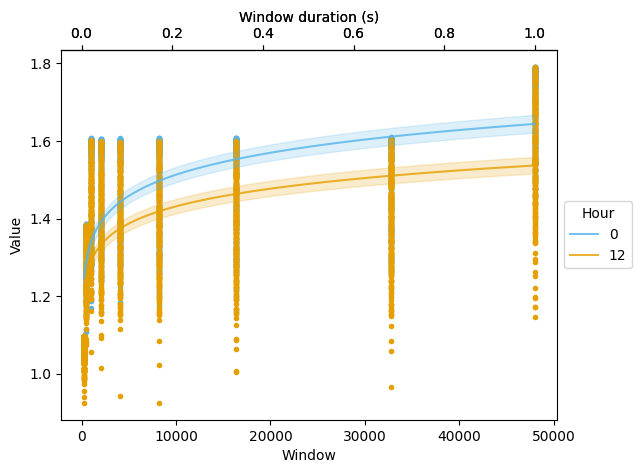

In [46]:
vicky_extracted_fish_ADI_fig


### Big Vicky - extracted shrimp ADI


In [47]:
vicky_extracted_shrimp_ADI_fig, vicky_extracted_shrimp_ADI_ratio_summary = experiment(vicky_df,
          shrimp_extracted_ADI_group,
          vicky_toolbox,
          r_link,
          marine=True,
          factors=['Hour', 'Site'],
          cross_effect='Hour')


shrimp using ADI
Compiling Stan program...

Start sampling

starting worker pid=91960 on localhost:11426 at 11:50:35.799
starting worker pid=91975 on localhost:11426 at 11:50:35.867
starting worker pid=91990 on localhost:11426 at 11:50:35.934
starting worker pid=92005 on localhost:11426 at 11:50:36.002
starting worker pid=92020 on localhost:11426 at 11:50:36.071

SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.000734 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 7.34 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 3000 [  0%]  (Warmup)

SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 2).
Chain 2: 
Chain 2: Gradient evaluation took 0.000711 seconds
Chain 2: 1000 transitions using 10 leapfrog steps per transition would take 7.11 seconds.
Chain 2: Adjust your expectations accordingly!
Chain 2: 
Chain 2: 
Chain 2: Iteration:    1 / 3000 [  0%]  (Warmup)

SAMP

/home/00112847/code/index_sensitivity/tools/plots.py:61: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for var_id, group in point_df.groupby(effect_names[1]):
/home/00112847/code/index_sensitivity/tools/plots.py:73: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for var_id, group in df.groupby(effect_names[1]):


In [48]:
print(vicky_extracted_shrimp_ADI_ratio_summary)


# A tibble: 9 × 7
  Window     y  ymin  ymax .width .point .interval
   <dbl> <dbl> <dbl> <dbl>  <dbl> <chr>  <chr>    
1   5.55 1.00  1.00  1.00    0.95 median hdci     
2   6.24 1.00  1.00  1.00    0.95 median hdci     
3   6.93 1.00  1.00  1.00    0.95 median hdci     
4   7.62 1.00  1.00  1.00    0.95 median hdci     
5   8.32 1.00  0.999 1.00    0.95 median hdci     
6   9.01 0.999 0.999 1.00    0.95 median hdci     
7   9.70 0.999 0.998 1.00    0.95 median hdci     
8  10.4  0.998 0.997 0.999   0.95 median hdci     
9  10.8  0.998 0.996 0.999   0.95 median hdci     



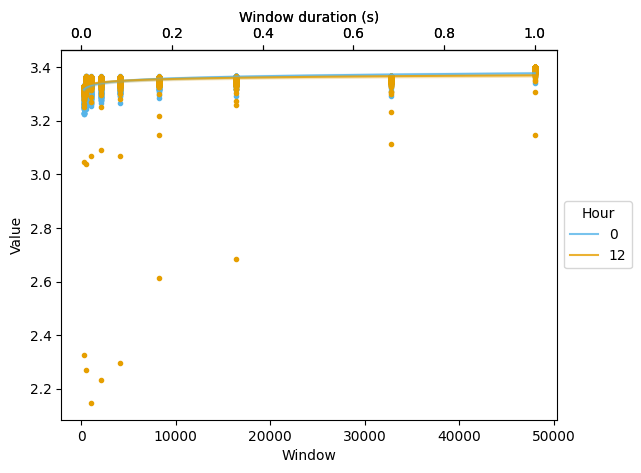

In [49]:
vicky_extracted_shrimp_ADI_fig


### Big Vicky - filtered fish ADI


In [50]:
vicky_filtered_fish_ADI_fig, vicky_filtered_fish_ADI_ratio_summary = experiment(vicky_df,
          fish_filtered_ADI_group,
          vicky_toolbox,
          r_link,
          marine=True,
          factors=['Hour', 'Site'],
          cross_effect='Hour')


fish  filteredusing ADI
Compiling Stan program...

Start sampling

starting worker pid=93276 on localhost:11426 at 11:56:56.390
starting worker pid=93291 on localhost:11426 at 11:56:56.460
starting worker pid=93306 on localhost:11426 at 11:56:56.528
starting worker pid=93321 on localhost:11426 at 11:56:56.595
starting worker pid=93336 on localhost:11426 at 11:56:56.661

SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.000747 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 7.47 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 3000 [  0%]  (Warmup)

SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 2).
Chain 2: 
Chain 2: Gradient evaluation took 0.000698 seconds
Chain 2: 1000 transitions using 10 leapfrog steps per transition would take 6.98 seconds.
Chain 2: Adjust your expectations accordingly!
Chain 2: 
Chain 2: 
Chain 2: Iteration:    1 / 3000 [  0%]  (Warmup

/home/00112847/code/index_sensitivity/tools/plots.py:61: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for var_id, group in point_df.groupby(effect_names[1]):
/home/00112847/code/index_sensitivity/tools/plots.py:73: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for var_id, group in df.groupby(effect_names[1]):


In [51]:
print(vicky_filtered_fish_ADI_ratio_summary)


# A tibble: 9 × 7
  Window     y  ymin  ymax .width .point .interval
   <dbl> <dbl> <dbl> <dbl>  <dbl> <chr>  <chr>    
1   5.55 0.912 0.907 0.916   0.95 median hdci     
2   6.24 0.910 0.905 0.913   0.95 median hdci     
3   6.93 0.908 0.904 0.911   0.95 median hdci     
4   7.62 0.905 0.903 0.908   0.95 median hdci     
5   8.32 0.903 0.901 0.906   0.95 median hdci     
6   9.01 0.901 0.898 0.904   0.95 median hdci     
7   9.70 0.899 0.896 0.902   0.95 median hdci     
8  10.4  0.897 0.893 0.901   0.95 median hdci     
9  10.8  0.896 0.891 0.900   0.95 median hdci     



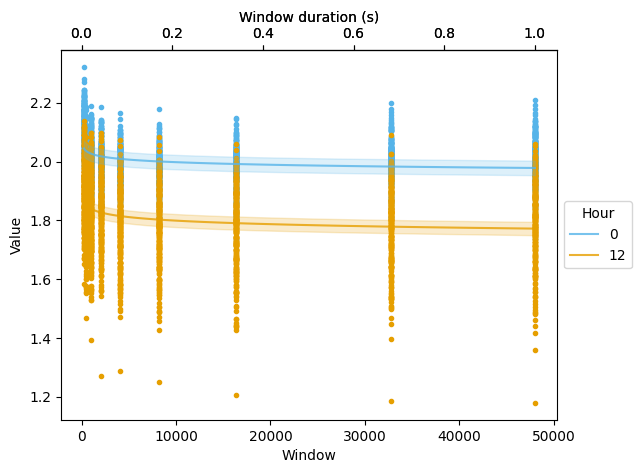

In [52]:
vicky_filtered_fish_ADI_fig


### Big Vicky - filtered shrimp ADI


In [53]:
vicky_filtered_shrimp_ADI_fig, vicky_filtered_shrimp_ADI_ratio_summary = experiment(vicky_df,
          shrimp_filtered_ADI_group,
          vicky_toolbox,
          r_link,
          marine=True,
          factors=['Hour', 'Site'],
          cross_effect='Hour')


shrimp  filteredusing ADI
Compiling Stan program...

Start sampling

starting worker pid=93848 on localhost:11426 at 11:59:12.263
starting worker pid=93863 on localhost:11426 at 11:59:12.330
starting worker pid=93878 on localhost:11426 at 11:59:12.397
starting worker pid=93893 on localhost:11426 at 11:59:12.466
starting worker pid=93908 on localhost:11426 at 11:59:12.534

SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.000708 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 7.08 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 3000 [  0%]  (Warmup)

SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 2).
Chain 2: 
Chain 2: Gradient evaluation took 0.000734 seconds
Chain 2: 1000 transitions using 10 leapfrog steps per transition would take 7.34 seconds.
Chain 2: Adjust your expectations accordingly!
Chain 2: 
Chain 2: 
Chain 2: Iteration:    1 / 3000 [  0%]  (Warm

/home/00112847/code/index_sensitivity/tools/plots.py:61: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for var_id, group in point_df.groupby(effect_names[1]):
/home/00112847/code/index_sensitivity/tools/plots.py:73: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for var_id, group in df.groupby(effect_names[1]):


In [54]:
print(vicky_filtered_shrimp_ADI_ratio_summary)


# A tibble: 9 × 7
  Window     y  ymin  ymax .width .point .interval
   <dbl> <dbl> <dbl> <dbl>  <dbl> <chr>  <chr>    
1   5.55 1.01  1.01  1.01    0.95 median hdci     
2   6.24 1.01  1.01  1.01    0.95 median hdci     
3   6.93 1.01  1.00  1.01    0.95 median hdci     
4   7.62 1.00  1.00  1.00    0.95 median hdci     
5   8.32 1.00  1.00  1.00    0.95 median hdci     
6   9.01 0.999 0.998 1.00    0.95 median hdci     
7   9.70 0.997 0.996 0.998   0.95 median hdci     
8  10.4  0.995 0.993 0.996   0.95 median hdci     
9  10.8  0.993 0.992 0.995   0.95 median hdci     



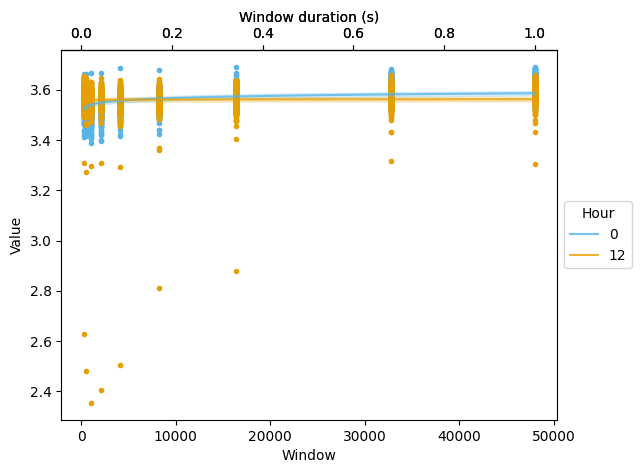

In [55]:
vicky_filtered_shrimp_ADI_fig


### Big Vicky - broadband AEI


In [56]:
vicky_extracted_broadband_AEI_fig, vicky_extracted_broadband_AEI_ratio_summary = experiment(vicky_df,
          broadband_AEI_group,
          vicky_toolbox,
          r_link,
          marine=True,
          factors=['Hour', 'Site'],
          cross_effect='Hour')


broadband using AEI
Compiling Stan program...

Start sampling

starting worker pid=95015 on localhost:11426 at 12:05:04.220
starting worker pid=95030 on localhost:11426 at 12:05:04.288
starting worker pid=95045 on localhost:11426 at 12:05:04.356
starting worker pid=95060 on localhost:11426 at 12:05:04.424
starting worker pid=95075 on localhost:11426 at 12:05:04.492

SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.001081 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 10.81 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 3000 [  0%]  (Warmup)

SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 2).
Chain 2: 
Chain 2: Gradient evaluation took 0.001057 seconds
Chain 2: 1000 transitions using 10 leapfrog steps per transition would take 10.57 seconds.
Chain 2: Adjust your expectations accordingly!
Chain 2: 
Chain 2: 
Chain 2: Iteration:    1 / 3000 [  0%]  (Warmup)


/home/00112847/code/index_sensitivity/tools/plots.py:61: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for var_id, group in point_df.groupby(effect_names[1]):
/home/00112847/code/index_sensitivity/tools/plots.py:73: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for var_id, group in df.groupby(effect_names[1]):


In [57]:
print(vicky_extracted_broadband_AEI_ratio_summary)


# A tibble: 9 × 7
  Window     y  ymin  ymax .width .point .interval
   <int> <dbl> <dbl> <dbl>  <dbl> <chr>  <chr>    
1    256 0.952 0.928 0.989   0.95 median hdci     
2    512 0.953 0.929 0.990   0.95 median hdci     
3   1024 0.955 0.932 0.991   0.95 median hdci     
4   2048 0.960 0.937 0.995   0.95 median hdci     
5   4096 0.969 0.946 1.00    0.95 median hdci     
6   8192 0.987 0.966 1.02    0.95 median hdci     
7  16384 1.03  1.01  1.05    0.95 median hdci     
8  32768 1.11  1.09  1.12    0.95 median hdci     
9  48000 1.20  1.17  1.23    0.95 median hdci     



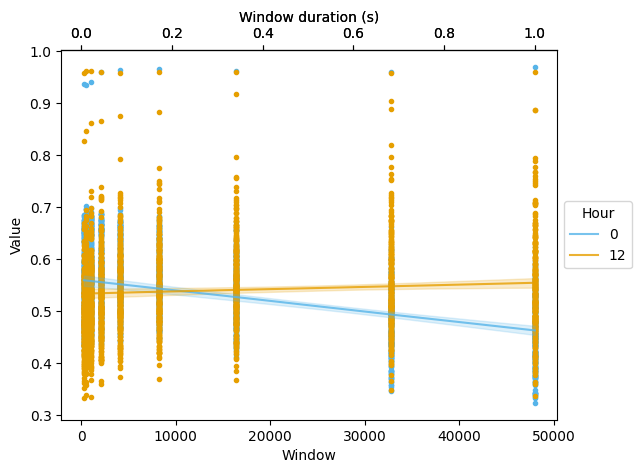

In [58]:
vicky_extracted_broadband_AEI_fig


### Big Vicky - extracted fish AEI


In [59]:
vicky_extracted_fish_AEI_fig, vicky_extracted_fish_AEI_ratio_summary = experiment(vicky_df,
          fish_extracted_AEI_group,
          vicky_toolbox,
          r_link,
          marine=True,
          factors=['Hour', 'Site'],
          cross_effect='Hour')


fish using AEI
Compiling Stan program...

Start sampling

starting worker pid=97390 on localhost:11426 at 12:32:25.912
starting worker pid=97405 on localhost:11426 at 12:32:25.980
starting worker pid=97420 on localhost:11426 at 12:32:26.047
starting worker pid=97435 on localhost:11426 at 12:32:26.114
starting worker pid=97450 on localhost:11426 at 12:32:26.181

SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.001043 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 10.43 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 3000 [  0%]  (Warmup)

SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 2).
Chain 2: 
Chain 2: Gradient evaluation took 0.00107 seconds
Chain 2: 1000 transitions using 10 leapfrog steps per transition would take 10.7 seconds.
Chain 2: Adjust your expectations accordingly!
Chain 2: 
Chain 2: 
Chain 2: Iteration:    1 / 3000 [  0%]  (Warmup)

SAMPLI

/home/00112847/code/index_sensitivity/tools/plots.py:61: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for var_id, group in point_df.groupby(effect_names[1]):
/home/00112847/code/index_sensitivity/tools/plots.py:73: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for var_id, group in df.groupby(effect_names[1]):


In [60]:
print(vicky_extracted_fish_AEI_ratio_summary)


# A tibble: 9 × 7
  Window     y  ymin  ymax .width .point .interval
   <int> <dbl> <dbl> <dbl>  <dbl> <chr>  <chr>    
1    256  1.42  1.37  1.47   0.95 median hdci     
2    512  1.42  1.37  1.47   0.95 median hdci     
3   1024  1.43  1.37  1.48   0.95 median hdci     
4   2048  1.43  1.37  1.48   0.95 median hdci     
5   4096  1.43  1.38  1.48   0.95 median hdci     
6   8192  1.44  1.40  1.49   0.95 median hdci     
7  16384  1.46  1.42  1.50   0.95 median hdci     
8  32768  1.50  1.43  1.56   0.95 median hdci     
9  48000  1.53  1.44  1.63   0.95 median hdci     



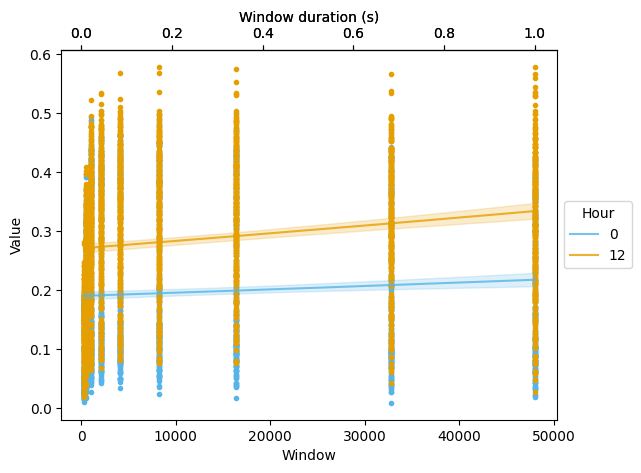

In [61]:
vicky_extracted_fish_AEI_fig


### Big Vicky - extracted shrimp AEI


In [62]:
vicky_extracted_shrimp_AEI_fig, vicky_extracted_shrimp_AEI_ratio_summary = experiment(vicky_df,
          shrimp_extracted_AEI_group,
          vicky_toolbox,
          r_link,
          marine=True,
          factors=['Hour', 'Site'],
          cross_effect='Hour')


shrimp using AEI
Compiling Stan program...

Start sampling

starting worker pid=99582 on localhost:11426 at 12:59:36.456
starting worker pid=99597 on localhost:11426 at 12:59:36.524
starting worker pid=99612 on localhost:11426 at 12:59:36.593
starting worker pid=99627 on localhost:11426 at 12:59:36.661
starting worker pid=99642 on localhost:11426 at 12:59:36.729

SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.00106 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 10.6 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 3000 [  0%]  (Warmup)

SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 2).
Chain 2: 
Chain 2: Gradient evaluation took 0.001053 seconds
Chain 2: 1000 transitions using 10 leapfrog steps per transition would take 10.53 seconds.
Chain 2: Adjust your expectations accordingly!
Chain 2: 
Chain 2: 
Chain 2: Iteration:    1 / 3000 [  0%]  (Warmup)

SAMP

/home/00112847/code/index_sensitivity/tools/plots.py:61: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for var_id, group in point_df.groupby(effect_names[1]):
/home/00112847/code/index_sensitivity/tools/plots.py:73: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for var_id, group in df.groupby(effect_names[1]):


In [63]:
print(vicky_extracted_shrimp_AEI_ratio_summary)


# A tibble: 9 × 7
  Window     y  ymin  ymax .width .point .interval
   <int> <dbl> <dbl> <dbl>  <dbl> <chr>  <chr>    
1    256 0.870 0.850 0.900   0.95 median hdci     
2    512 0.873 0.852 0.902   0.95 median hdci     
3   1024 0.879 0.858 0.908   0.95 median hdci     
4   2048 0.890 0.871 0.920   0.95 median hdci     
5   4096 0.914 0.894 0.941   0.95 median hdci     
6   8192 0.965 0.944 0.990   0.95 median hdci     
7  16384 1.08  1.05  1.10    0.95 median hdci     
8  32768 1.35  1.29  1.41    0.95 median hdci     
9  48000 1.67  1.56  1.78    0.95 median hdci     



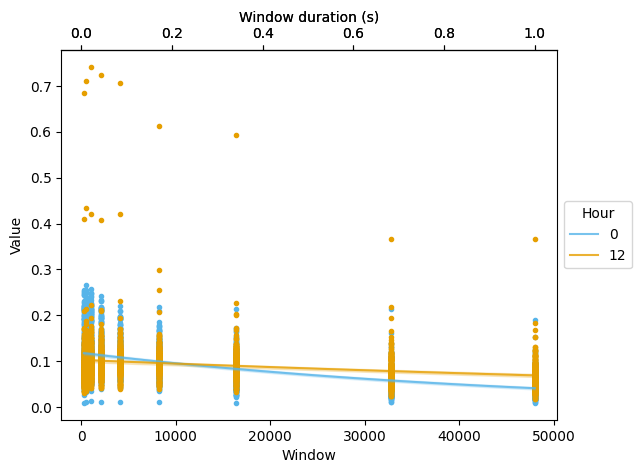

In [64]:
vicky_extracted_shrimp_AEI_fig


### Big Vicky - filtered fish AEI


In [65]:
vicky_filtered_fish_AEI_fig, vicky_filtered_fish_AEI_ratio_summary = experiment(vicky_df,
          fish_filtered_AEI_group,
          vicky_toolbox,
          r_link,
          marine=True,
          factors=['Hour', 'Site'],
          cross_effect='Hour')


fish  filteredusing AEI
Compiling Stan program...

Start sampling

starting worker pid=101974 on localhost:11426 at 13:26:34.583
starting worker pid=101989 on localhost:11426 at 13:26:34.651
starting worker pid=102004 on localhost:11426 at 13:26:34.719
starting worker pid=102019 on localhost:11426 at 13:26:34.787
starting worker pid=102034 on localhost:11426 at 13:26:34.854

SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.001081 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 10.81 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 3000 [  0%]  (Warmup)

SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 2).
Chain 2: 
Chain 2: Gradient evaluation took 0.001083 seconds
Chain 2: 1000 transitions using 10 leapfrog steps per transition would take 10.83 seconds.
Chain 2: Adjust your expectations accordingly!
Chain 2: 
Chain 2: 
Chain 2: Iteration:    1 / 3000 [  0%]  

/home/00112847/code/index_sensitivity/tools/plots.py:61: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for var_id, group in point_df.groupby(effect_names[1]):
/home/00112847/code/index_sensitivity/tools/plots.py:73: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for var_id, group in df.groupby(effect_names[1]):


In [66]:
print(vicky_filtered_fish_AEI_ratio_summary)


# A tibble: 9 × 7
  Window     y  ymin  ymax .width .point .interval
   <int> <dbl> <dbl> <dbl>  <dbl> <chr>  <chr>    
1    256  1.00  1.00  1.00   0.95 median hdci     
2    512  1.00  1.00  1.00   0.95 median hdci     
3   1024  1.00  1.00  1.01   0.95 median hdci     
4   2048  1.00  1.00  1.01   0.95 median hdci     
5   4096  1.00  1.00  1.01   0.95 median hdci     
6   8192  1.00  1.00  1.01   0.95 median hdci     
7  16384  1.01  1.00  1.01   0.95 median hdci     
8  32768  1.01  1.01  1.01   0.95 median hdci     
9  48000  1.01  1.01  1.01   0.95 median hdci     



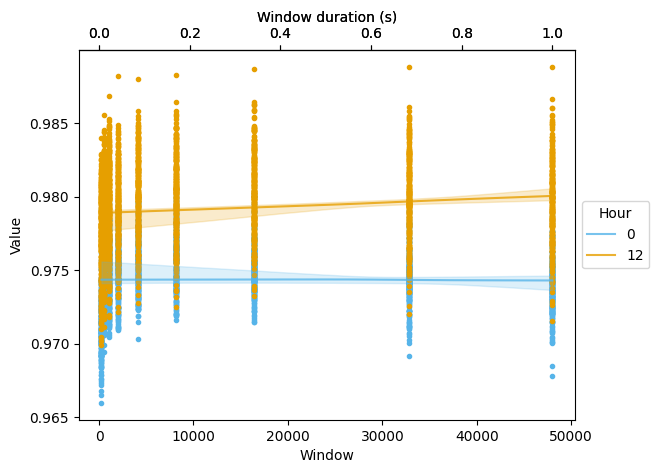

In [67]:
vicky_filtered_fish_AEI_fig


### Big Vicky - filtered shrimp AEI


In [68]:
vicky_filtered_shrimp_AEI_fig, vicky_filtered_shrimp_AEI_ratio_summary = experiment(vicky_df,
          shrimp_filtered_AEI_group,
          vicky_toolbox,
          r_link,
          marine=True,
          factors=['Hour', 'Site'],
          cross_effect='Hour')


shrimp  filteredusing AEI
Compiling Stan program...

Start sampling

starting worker pid=104288 on localhost:11426 at 13:53:21.892
starting worker pid=104303 on localhost:11426 at 13:53:21.960
starting worker pid=104318 on localhost:11426 at 13:53:22.028
starting worker pid=104333 on localhost:11426 at 13:53:22.095
starting worker pid=104348 on localhost:11426 at 13:53:22.163

SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.001061 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 10.61 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 3000 [  0%]  (Warmup)

SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 2).
Chain 2: 
Chain 2: Gradient evaluation took 0.00171 seconds
Chain 2: 1000 transitions using 10 leapfrog steps per transition would take 17.1 seconds.
Chain 2: Adjust your expectations accordingly!
Chain 2: 
Chain 2: 
Chain 2: Iteration:    1 / 3000 [  0%]  

/home/00112847/code/index_sensitivity/tools/plots.py:61: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for var_id, group in point_df.groupby(effect_names[1]):
/home/00112847/code/index_sensitivity/tools/plots.py:73: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for var_id, group in df.groupby(effect_names[1]):


In [69]:
print(vicky_filtered_shrimp_AEI_ratio_summary)


# A tibble: 9 × 7
  Window     y  ymin  ymax .width .point .interval
   <int> <dbl> <dbl> <dbl>  <dbl> <chr>  <chr>    
1    256 0.999 0.998  1.00   0.95 median hdci     
2    512 0.999 0.998  1.00   0.95 median hdci     
3   1024 0.999 0.998  1.00   0.95 median hdci     
4   2048 1.00  0.998  1.00   0.95 median hdci     
5   4096 1.00  0.999  1.00   0.95 median hdci     
6   8192 1.00  1.00   1.00   0.95 median hdci     
7  16384 1.00  1.00   1.00   0.95 median hdci     
8  32768 1.01  1.00   1.01   0.95 median hdci     
9  48000 1.01  1.01   1.01   0.95 median hdci     



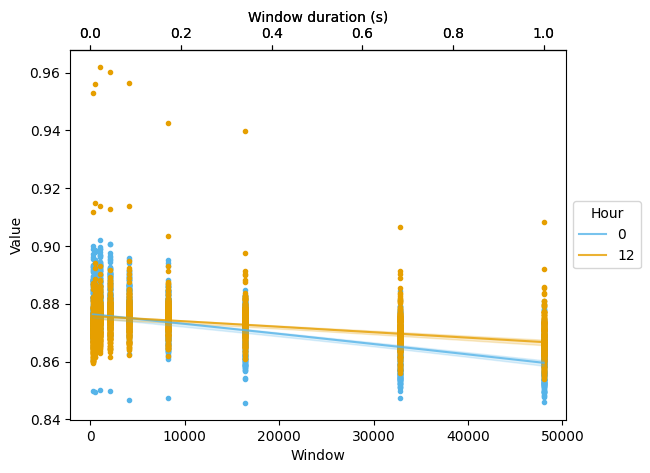

In [70]:
vicky_filtered_shrimp_AEI_fig


### Big Vicky - broadband BIO


In [71]:
vicky_extracted_broadband_BIO_fig, vicky_extracted_broadband_BIO_ratio_summary = experiment(vicky_df,
          broadband_BIO_group,
          vicky_toolbox,
          r_link,
          marine=True,
          factors=['Hour', 'Site'],
          cross_effect='Hour')


broadband using BIO
Compiling Stan program...

Start sampling

starting worker pid=106765 on localhost:11426 at 14:20:16.356
starting worker pid=106780 on localhost:11426 at 14:20:16.424
starting worker pid=106795 on localhost:11426 at 14:20:16.492
starting worker pid=106810 on localhost:11426 at 14:20:16.560
starting worker pid=106825 on localhost:11426 at 14:20:16.627

SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.001868 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 18.68 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 3000 [  0%]  (Warmup)

SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 2).
Chain 2: 
Chain 2: Gradient evaluation took 0.001923 seconds
Chain 2: 1000 transitions using 10 leapfrog steps per transition would take 19.23 seconds.
Chain 2: Adjust your expectations accordingly!
Chain 2: 
Chain 2: 
Chain 2: Iteration:    1 / 3000 [  0%]  (War

/home/00112847/code/index_sensitivity/tools/plots.py:61: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for var_id, group in point_df.groupby(effect_names[1]):
/home/00112847/code/index_sensitivity/tools/plots.py:73: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for var_id, group in df.groupby(effect_names[1]):


In [72]:
print(vicky_extracted_broadband_BIO_ratio_summary)


# A tibble: 9 × 7
  Window     y  ymin  ymax .width .point .interval
   <dbl> <dbl> <dbl> <dbl>  <dbl> <chr>  <chr>    
1   5.55 0.916 0.908 0.925   0.95 median hdci     
2   6.24 0.905 0.898 0.912   0.95 median hdci     
3   6.93 0.894 0.888 0.899   0.95 median hdci     
4   7.62 0.883 0.878 0.887   0.95 median hdci     
5   8.32 0.872 0.867 0.876   0.95 median hdci     
6   9.01 0.861 0.856 0.866   0.95 median hdci     
7   9.70 0.851 0.845 0.856   0.95 median hdci     
8  10.4  0.840 0.834 0.847   0.95 median hdci     
9  10.8  0.834 0.827 0.842   0.95 median hdci     



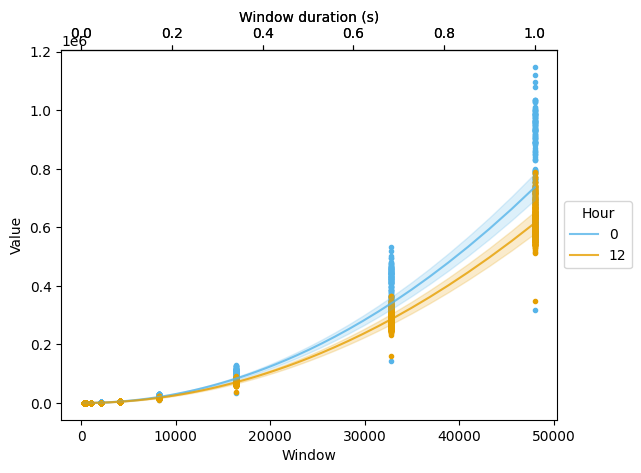

In [73]:
vicky_extracted_broadband_BIO_fig


### Big Vicky - extracted fish BIO


In [74]:
vicky_extracted_fish_BIO_fig, vicky_extracted_fish_BIO_ratio_summary = experiment(vicky_df,
          fish_extracted_BIO_group,
          vicky_toolbox,
          r_link,
          marine=True,
          factors=['Hour', 'Site'],
          cross_effect='Hour')


fish using BIO
Compiling Stan program...

Start sampling

starting worker pid=108967 on localhost:11426 at 14:28:09.273
starting worker pid=108982 on localhost:11426 at 14:28:09.341
starting worker pid=108997 on localhost:11426 at 14:28:09.410
starting worker pid=109012 on localhost:11426 at 14:28:09.480
starting worker pid=109027 on localhost:11426 at 14:28:09.549

SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.00197 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 19.7 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 3000 [  0%]  (Warmup)

SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 2).
Chain 2: 
Chain 2: Gradient evaluation took 0.002048 seconds
Chain 2: 1000 transitions using 10 leapfrog steps per transition would take 20.48 seconds.
Chain 2: Adjust your expectations accordingly!
Chain 2: 
Chain 2: 
Chain 2: Iteration:    1 / 3000 [  0%]  (Warmup)

S

/home/00112847/code/index_sensitivity/tools/plots.py:61: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for var_id, group in point_df.groupby(effect_names[1]):
/home/00112847/code/index_sensitivity/tools/plots.py:73: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for var_id, group in df.groupby(effect_names[1]):


In [75]:
print(vicky_extracted_fish_BIO_ratio_summary)


# A tibble: 9 × 7
  Window     y  ymin  ymax .width .point .interval
   <dbl> <dbl> <dbl> <dbl>  <dbl> <chr>  <chr>    
1   5.55 1.00  0.956 1.05    0.95 median hdci     
2   6.24 0.968 0.931 1.01    0.95 median hdci     
3   6.93 0.937 0.908 0.969   0.95 median hdci     
4   7.62 0.907 0.882 0.931   0.95 median hdci     
5   8.32 0.878 0.856 0.900   0.95 median hdci     
6   9.01 0.851 0.827 0.873   0.95 median hdci     
7   9.70 0.823 0.797 0.850   0.95 median hdci     
8  10.4  0.797 0.765 0.828   0.95 median hdci     
9  10.8  0.783 0.751 0.819   0.95 median hdci     



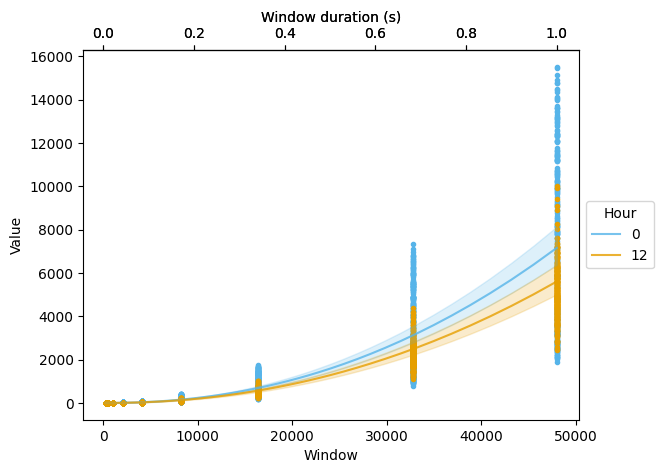

In [76]:
vicky_extracted_fish_BIO_fig


### Big Vicky - extracted shrimp BIO


In [77]:
vicky_extracted_shrimp_BIO_fig, vicky_extracted_shrimp_BIO_ratio_summary = experiment(vicky_df,
          shrimp_extracted_BIO_group,
          vicky_toolbox,
          r_link,
          marine=True,
          factors=['Hour', 'Site'],
          cross_effect='Hour')


shrimp using BIO
Compiling Stan program...

Start sampling

starting worker pid=110113 on localhost:11426 at 14:33:15.772
starting worker pid=110128 on localhost:11426 at 14:33:15.841
starting worker pid=110143 on localhost:11426 at 14:33:15.910
starting worker pid=110158 on localhost:11426 at 14:33:15.978
starting worker pid=110173 on localhost:11426 at 14:33:16.045

SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.001966 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 19.66 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 3000 [  0%]  (Warmup)

SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 2).
Chain 2: 
Chain 2: Gradient evaluation took 0.001939 seconds
Chain 2: 1000 transitions using 10 leapfrog steps per transition would take 19.39 seconds.
Chain 2: Adjust your expectations accordingly!
Chain 2: 
Chain 2: 
Chain 2: Iteration:    1 / 3000 [  0%]  (Warmup

/home/00112847/code/index_sensitivity/tools/plots.py:61: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for var_id, group in point_df.groupby(effect_names[1]):
/home/00112847/code/index_sensitivity/tools/plots.py:73: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for var_id, group in df.groupby(effect_names[1]):


In [78]:
print(vicky_extracted_shrimp_BIO_ratio_summary)


# A tibble: 9 × 7
  Window     y  ymin  ymax .width .point .interval
   <dbl> <dbl> <dbl> <dbl>  <dbl> <chr>  <chr>    
1   5.55  1.10  1.08  1.12   0.95 median hdci     
2   6.24  1.11  1.09  1.12   0.95 median hdci     
3   6.93  1.11  1.10  1.13   0.95 median hdci     
4   7.62  1.11  1.10  1.13   0.95 median hdci     
5   8.32  1.12  1.11  1.13   0.95 median hdci     
6   9.01  1.12  1.11  1.14   0.95 median hdci     
7   9.70  1.13  1.11  1.14   0.95 median hdci     
8  10.4   1.13  1.11  1.15   0.95 median hdci     
9  10.8   1.14  1.11  1.16   0.95 median hdci     



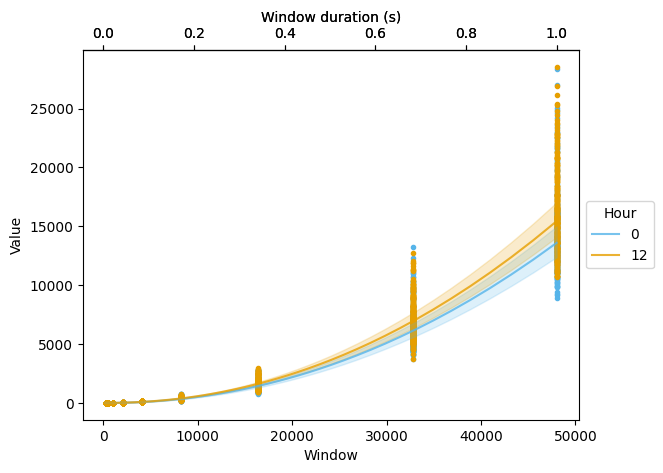

In [79]:
vicky_extracted_shrimp_BIO_fig


### Big Vicky - filtered fish BIO


In [80]:
vicky_filtered_fish_BIO_fig, vicky_filtered_fish_BIO_ratio_summary = experiment(vicky_df,
          fish_filtered_BIO_group,
          vicky_toolbox,
          r_link,
          marine=True,
          factors=['Hour', 'Site'],
          cross_effect='Hour')


fish  filteredusing BIO
Compiling Stan program...

Start sampling

starting worker pid=111418 on localhost:11426 at 14:39:48.406
starting worker pid=111433 on localhost:11426 at 14:39:48.473
starting worker pid=111448 on localhost:11426 at 14:39:48.541
starting worker pid=111463 on localhost:11426 at 14:39:48.610
starting worker pid=111496 on localhost:11426 at 14:39:48.678

SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.001933 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 19.33 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 3000 [  0%]  (Warmup)

SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 2).
Chain 2: 
Chain 2: Gradient evaluation took 0.001906 seconds
Chain 2: 1000 transitions using 10 leapfrog steps per transition would take 19.06 seconds.
Chain 2: Adjust your expectations accordingly!
Chain 2: 
Chain 2: 
Chain 2: Iteration:    1 / 3000 [  0%]  

/home/00112847/code/index_sensitivity/tools/plots.py:61: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for var_id, group in point_df.groupby(effect_names[1]):
/home/00112847/code/index_sensitivity/tools/plots.py:73: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for var_id, group in df.groupby(effect_names[1]):


In [81]:
print(vicky_filtered_fish_BIO_ratio_summary)


# A tibble: 9 × 7
  Window     y  ymin  ymax .width .point .interval
   <dbl> <dbl> <dbl> <dbl>  <dbl> <chr>  <chr>    
1   5.55 0.954 0.951 0.957   0.95 median hdci     
2   6.24 0.947 0.945 0.949   0.95 median hdci     
3   6.93 0.940 0.938 0.942   0.95 median hdci     
4   7.62 0.933 0.932 0.935   0.95 median hdci     
5   8.32 0.926 0.925 0.928   0.95 median hdci     
6   9.01 0.920 0.918 0.921   0.95 median hdci     
7   9.70 0.913 0.911 0.915   0.95 median hdci     
8  10.4  0.906 0.903 0.908   0.95 median hdci     
9  10.8  0.902 0.899 0.905   0.95 median hdci     



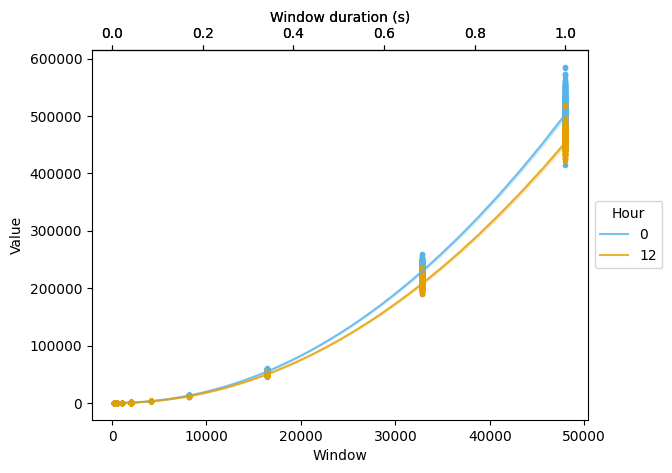

In [82]:
vicky_filtered_fish_BIO_fig


### Big Vicky - filtered shrimp BIO


In [83]:
vicky_filtered_shrimp_BIO_fig, vicky_filtered_shrimp_BIO_ratio_summary = experiment(vicky_df,
          shrimp_filtered_BIO_group,
          vicky_toolbox,
          r_link,
          marine=True,
          factors=['Hour', 'Site'],
          cross_effect='Hour')


shrimp  filteredusing BIO
Compiling Stan program...

Start sampling

starting worker pid=113167 on localhost:11426 at 14:52:22.996
starting worker pid=113182 on localhost:11426 at 14:52:23.064
starting worker pid=113197 on localhost:11426 at 14:52:23.132
starting worker pid=113212 on localhost:11426 at 14:52:23.200
starting worker pid=113227 on localhost:11426 at 14:52:23.267

SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.00198 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 19.8 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 3000 [  0%]  (Warmup)

SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 2).
Chain 2: 
Chain 2: Gradient evaluation took 0.001938 seconds
Chain 2: 1000 transitions using 10 leapfrog steps per transition would take 19.38 seconds.
Chain 2: Adjust your expectations accordingly!
Chain 2: 
Chain 2: 
Chain 2: Iteration:    1 / 3000 [  0%]  

/home/00112847/code/index_sensitivity/tools/plots.py:61: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for var_id, group in point_df.groupby(effect_names[1]):
/home/00112847/code/index_sensitivity/tools/plots.py:73: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for var_id, group in df.groupby(effect_names[1]):


In [84]:
print(vicky_filtered_shrimp_BIO_ratio_summary)


# A tibble: 9 × 7
  Window     y  ymin  ymax .width .point .interval
   <dbl> <dbl> <dbl> <dbl>  <dbl> <chr>  <chr>    
1   5.55  1.01  1.01  1.01   0.95 median hdci     
2   6.24  1.01  1.01  1.02   0.95 median hdci     
3   6.93  1.02  1.01  1.02   0.95 median hdci     
4   7.62  1.02  1.02  1.02   0.95 median hdci     
5   8.32  1.02  1.02  1.02   0.95 median hdci     
6   9.01  1.02  1.02  1.02   0.95 median hdci     
7   9.70  1.02  1.02  1.03   0.95 median hdci     
8  10.4   1.03  1.02  1.03   0.95 median hdci     
9  10.8   1.03  1.02  1.03   0.95 median hdci     



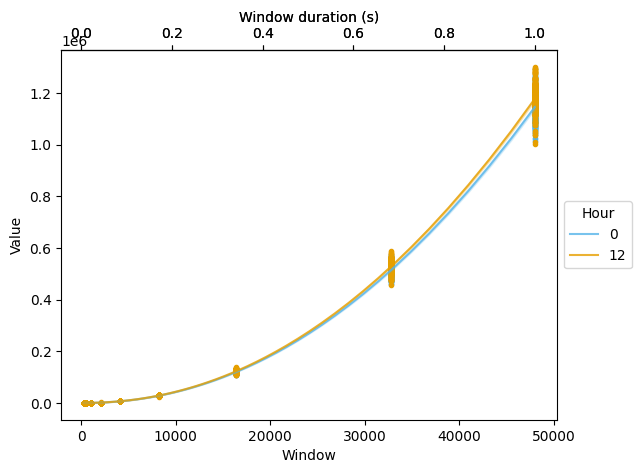

In [85]:
vicky_filtered_shrimp_BIO_fig
